What is NOT included in this notebook is the script used to pull images since I forgot to upload it (it's on my big rig at home).

The script pulls 20k images from google's open images and creates usable datasets. 10k are cat pictures, 10k are non-cats. The script then takes each folder and divides the images into directories as follows:


```
dataset/
  train/
    cats/
    non_cats/
  test/
    cats/
    non_cats/
  val/
    cats/
    non_cats/
```

80% for training, 10% for testing, and 10% for validation.

In short, 8k/1k/1k for cats and 8k/1k/1k for non-cats.

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
#import h5py # some issues with importing h5py. Will figure this out if needed.
import os

In [ ]:
# Define dataset path
DATASET_PATH = "dataset"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Load datasets. Might need to change later.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

Found 16000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Images are rotated and flipped randomly.

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# Normalize pixel values (rescale to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

The model was based on a pre-trained model to speed things along since I don't have a GPU. There were issues with overfitting early on, so I decided to freeze the first 100 layers and leave the rest open for training. I also implemented early stopping to prevent overfitting during training.

The base model, mobileNetV2, was selected because it balances speed and accuracy and is relatively lightweight, which makes it suited for deployment on a raspberry pi.

In [ ]:
# Load MobileNetV2 without top layers (pretrained on ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze first 100 layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
# Build custom model
# THIS MIGHT NEED ADJUSTMENT LATER
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # dropout to reduce overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary classification
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# crossentropy: cat vs non-cat, 0 or 1

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Train the model
EPOCHS = 20  # tends to stop at 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 280ms/step - accuracy: 0.8694 - loss: 0.2979 - val_accuracy: 0.9580 - val_loss: 0.1657
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - accuracy: 0.9362 - loss: 0.1742 - val_accuracy: 0.9630 - val_loss: 0.1332
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 278ms/step - accuracy: 0.9479 - loss: 0.1492 - val_accuracy: 0.9565 - val_loss: 0.1318
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 0.9540 - loss: 0.1279 - val_accuracy: 0.9375 - val_loss: 0.2304
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 279ms/step - accuracy: 0.9549 - loss: 0.1227 - val_accuracy: 0.9555 - val_loss: 0.1677
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - accuracy: 0.9613 - loss: 0.1036 - val_accuracy: 0.9650 - val_loss: 0.1279
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - accuracy: 0.9650 - loss: 0.0997 - val_accuracy: 0.9615 - val_loss: 0.1186
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - accuracy: 0.9666 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9654 - loss: 0.1237
Test Accuracy: 0.9675


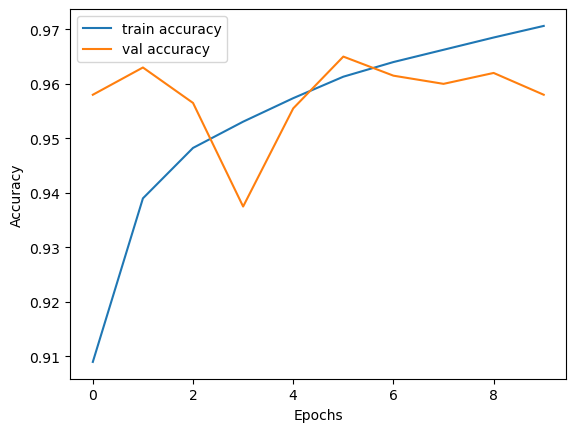

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Save as h5 for pi deployment
model.save("cat_detector.h5")
print("Model saved as cat_detector.h5")

Model saved as cat_detector.h5


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,473,157 (24.69 MB)

 Trainable params: 2,025,537 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,051,076 (15.45 MB)

TESTING ON IMAGES

In [ ]:
import tensorflow as tf
#import keras_preprocessing
#from keras import preprocessing
from keras_preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the saved model
# Ignore the compilation warning--don't have to bother with it ATM
model = tf.keras.models.load_model("cat_detector.h5")

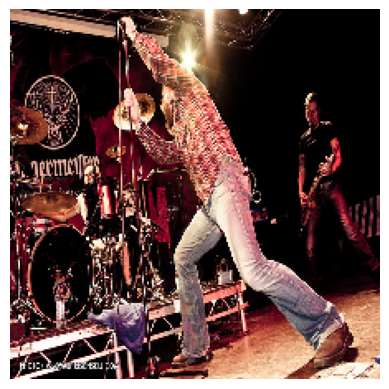

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction value: 0.9997
It's not a cat.


In [ ]:
image_path = "5200698631_f85e6dbb9d_z.jpg"

img = image.load_img(image_path, target_size=(224, 224))  # Resize
plt.imshow(img)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize to [0, 1]

prediction = model.predict(img_array) # this needs to be adjusted

# Debug
print(f"Prediction shape: {prediction.shape}")
print(f"Prediction value: {prediction[0][0]:.4f}")

if prediction[0][0] < 0.5:
    print("It's a cat!")
else:
    print("It's not a cat.")

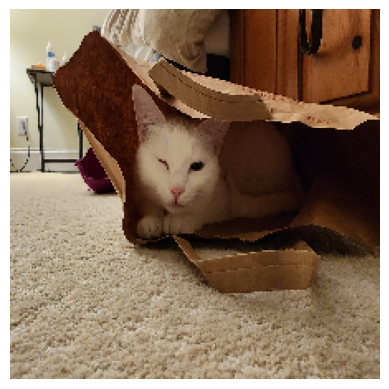

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction shape: (1, 1)
Prediction value: 0.0000
It's a cat!


In [ ]:
image_path = "20231213_062238.jpg"

img = image.load_img(image_path, target_size=(224, 224))  # Resize
plt.imshow(img)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize to [0, 1]

prediction = model.predict(img_array)

# Debug
print(f"Prediction shape: {prediction.shape}")
print(f"Prediction value: {prediction[0][0]:.4f}")

if prediction[0][0] < 0.5:
    print("It's a cat!")
else:
    print("It's not a cat.")

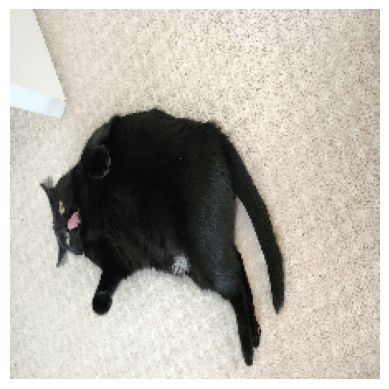

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction shape: (1, 1)
Prediction value: 0.0000
It's a cat!


In [ ]:
image_path = "20240418_123224.jpg"

img = image.load_img(image_path, target_size=(224, 224))  # Resize
plt.imshow(img)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize to [0, 1]

prediction = model.predict(img_array)

# Debug
print(f"Prediction shape: {prediction.shape}")
print(f"Prediction value: {prediction[0][0]:.4f}")

if prediction[0][0] < 0.5:
    print("It's a cat!")
else:
    print("It's not a cat.")